In [130]:
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
import mlxtend
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

from lazypredict.Supervised import LazyClassifier

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_rows', 150)  # показывать больше строк
pd.set_option('display.max_columns', 150)  # показывать больше колонок

In [131]:
def outliers(data: pd.DataFrame, column: str):

    '''Определение границ и выбросов'''

    data = data.copy()
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    IQR = q3 - q1
    mask25 = q1 - IQR * 1.5                   
    mask75 = q3 + IQR * 1.5

    values = {}
    values['borders'] = mask25, mask75
    values['# outliers'] = data[(data[column] < mask25)].shape[0], data[data[column] > mask75].shape[0]

    return pd.DataFrame.from_dict(data=values, orient='index', columns=['left', 'right'])

In [132]:
train = pd.read_csv('/content/drive/MyDrive/data.csv', sep=';')
test = pd.read_csv('/content/drive/MyDrive/verify.csv', sep=';')

In [133]:
print(train.info())
print()
print('Train size: ', train.shape)
print()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255820 entries, 0 to 255819
Columns: 126 entries, ID to target
dtypes: float64(21), int64(105)
memory usage: 245.9 MB
None

Train size:  (255820, 126)



,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
0,1,1,0,0,1381,63,0,0,1,0,0,0,1,0,0,0,0,229,0,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25000,10330,20330,35000,0,0,0.00,140.00,0.02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,19,24,956,4,50.00,345,0.07,0.69,0,13,0,0.00,4,0.00,1,39,0,2.00,20,0.05,61.00,0.00,23.00,100.00,0.61,0,4,0.21,0,0,0,0.00,0,0,0,0,0,0.00,7000,4000,7526.32,12000,0.58,0
1,2,0,0,0,1809,33,1,0,1,0,0,1,0,0,0,0,0,67,2,0.70,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,22000,25000,25000,55000,0,1,0.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,61,4,407,1,6.00,24,0.17,0.22,0,1,0,0.00,1,0.00,0,2,0,0.00,1,0.00,0.00,0.00,23.00,208.00,0.00,1,5,0.08,0,0,0,0.00,0,0,0,0,0,0.00,10000,1000,8393.44,30000,0.33,0
2,3,0,0,0,1804,29,0,1,0,0,0,1,0,0,0,0,0,185,0,3.00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,5000,30000,40000,40000,0,1,0.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,54,3,1178,1,21.00,123,0.02,0.65,0,20,0,0.00,8,0.00,0,18,0,0.00,5,0.00,16.00,0.00,11.00,115.00,0.14,0,3,0.06,0,5,5,0.09,0,1,0,0,0,0.00,3000,1000,3425.93,15000,0.20,0
3,4,0,0,0,1560,28,1,1,0,0,0,0,1,0,0,0,0,252,1,5.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,10000,25000,25000,25000,0,1,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,75,8,623,0,8.00,37,0.22,0.40,0,4,0,0.00,1,0.00,0,16,0,0.00,3,0.00,5.00,1.00,12.00,116.00,0.04,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0.00,2000,1000,1946.67,3000,0.67,0
4,5,0,0,0,258,33,1,0,0,0,1,0,1,0,0,0,0,4,2,0.10,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,10000,17000,25400,25400,0,1,0.00,0.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,9,10,77,1,8.00,18,0.56,0.30,0,2,0,0.00,1,0.00,0,0,0,0.00,0,1.00,1.00,1.00,4.00,14.00,0.07,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0.00,2000,2000,4444.44,8000,0.25,0


In [134]:
print(test.info())
print()
print('Test size: ', test.shape)
print()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56030 entries, 0 to 56029
Columns: 125 entries, ID to feature_124
dtypes: float64(21), int64(104)
memory usage: 53.4 MB
None

Test size:  (56030, 125)



,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124
0,255821,0,0,0,2268,34,0,1,0,0,0,0,0,0,1,0,1,119,0,6.30,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,11000,28000,35000,35000,0,1,0.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,49,14,804,0,16.00,261,0.05,0.35,7,61,0,1.00,8,0.88,0,1,0,0.00,1,0.00,42.00,0.00,30.00,239.00,0.18,0,2,0.04,0,1,1,0.02,0,1,0,0,0,0.00,6000,1000,4551.02,12000,0.50
1,255822,0,0,0,42,49,0,0,1,0,0,0,1,0,0,0,0,265,0,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000,8600,19600,35000,0,0,0.00,1000.00,0.17,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,13,22,9,11.00,13,1.00,0.52,0,0,0,0.00,0,1.00,0,0,0,0.00,0,1.00,20.00,20.00,20.00,20.00,1.00,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0.00,6000,3400,4700.00,6000,1.00
2,255823,0,0,0,265,69,0,1,0,0,0,0,0,1,0,0,1,134,0,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5000,10000,10000,10000,0,0,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,3,16,45,14,15.00,16,1.00,0.17,0,0,0,0.00,0,1.00,0,0,0,0.00,0,1.00,203.00,17.00,110.00,203.00,1.00,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0.00,3000,3000,4133.33,6000,0.50
3,255824,1,0,0,834,25,1,0,1,0,0,0,1,0,0,0,0,34,0,0.30,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,10000,40000,50000,80000,0,1,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,32,37,187,1,5.00,37,1.00,0.22,4,15,0,0.00,4,1.00,0,5,0,0.00,4,0.00,15.00,0.00,20.00,185.00,0.08,0,1,0.03,0,0,0,0.00,0,0,0,0,0,0.00,2000,1000,3875.00,11000,0.18
4,255825,0,0,0,772,26,1,1,0,0,0,0,0,1,0,0,1,80,1,2.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,7000,16000,17500,30000,0,1,0.00,1200.00,0.15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,5,2,120,1,24.00,90,0.02,0.16,0,1,0,0.00,1,0.00,0,0,0,0.00,0,1.00,142.00,1.00,163.00,488.00,0.29,0,0,0.00,0,1,1,0.20,0,1,0,0,0,0.00,8000,2000,7640.00,12000,0.67


In [135]:
train['sample'] = 1   # train
test['sample'] = 0    # test
test['target'] = -1  # imaginary value for now
all_data = pd.concat([train, test], join='inner', ignore_index=True)

In [136]:
all_data

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target,sample
0,1,1,0,0,1381,63,0,0,1,0,0,0,1,0,0,0,0,229,0,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25000,10330,20330,35000,0,0,0.00,140.00,0.02,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,19,24,956,4,50.00,345,0.07,0.69,0,13,0,0.00,4,0.00,1,39,0,2.00,20,0.05,61.00,0.00,23.00,100.00,0.61,0,4,0.21,0,0,0,0.00,0,0,0,0,0,0.00,7000,4000,7526.32,12000,0.58,0,1
1,2,0,0,0,1809,33,1,0,1,0,0,1,0,0,0,0,0,67,2,0.70,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,22000,25000,25000,55000,0,1,0.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,61,4,407,1,6.00,24,0.17,0.22,0,1,0,0.00,1,0.00,0,2,0,0.00,1,0.00,0.00,0.00,23.00,208.00,0.00,1,5,0.08,0,0,0,0.00,0,0,0,0,0,0.00,10000,1000,8393.44,30000,0.33,0,1
2,3,0,0,0,1804,29,0,1,0,0,0,1,0,0,0,0,0,185,0,3.00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,5000,30000,40000,40000,0,1,0.00,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,54,3,1178,1,21.00,123,0.02,0.65,0,20,0,0.00,8,0.00,0,18,0,0.00,5,0.00,16.00,0.00,11.00,115.00,0.14,0,3,0.06,0,5,5,0.09,0,1,0,0,0,0.00,3000,1000,3425.93,15000,0.20,0,1
3,4,0,0,0,1560,28,1,1,0,0,0,0,1,0,0,0,0,252,1,5.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,10000,25000,25000,25000,0,1,0.00,0.00,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,75,8,623,0,8.00,37,0.22,0.40,0,4,0,0.00,1,0.00,0,16,0,0.00,3,0.00,5.00,1.00,12.00,116.00,0.04,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0.00,2000,1000,1946.67,3000,0.67,0,1
4,5,0,0,0,258,33,1,0,0,0,1,0,1,0,0,0,0,4,2,0.10,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,10000,17000,25400,25400,0,1,0.00,0.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,9,10,77,1,8.00,18,0.56,0.30,0,2,0,0.00,1,0.00,0,0,0,0.00,0,1.00,1.00,1.00,4.00,14.00,0.07,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0.00,2000,2000,4444.44,8000,0.25,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311845,311846,0,0,0,58,27,0,0,1,0,0,0,0,1,0,0,1,0,0,4.00,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8000,35000,45000,70000,0,0,0.00,1500.00,0.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,5,7,38,1,7.00,22,0.32,0.66,1,1,0,0.00,1,1.00,0,0,0,0.00,0,1.00,7.00,3.

In [137]:
# pandas_profiling.ProfileReport(all_data)

### Выводы
- 49 numeric column, 75 categorical           
- пропусков 0.8% в колонках колонках 102-106 и 121-124, с максимальным значением 23%                
- много сильно кореллирующихся признаков, нужно будет применить отбор важных признаков
- 'feature_51' в тестовой выборке имеет только одно уникальное значение             
- target не сбалансирована                
 

In [138]:
all_data.feature_102 = all_data.feature_102.fillna(all_data.feature_102.median())
all_data.feature_103 = all_data.feature_103.fillna(all_data.feature_103.median())
all_data.feature_104 = all_data.feature_104.fillna(all_data.feature_104.median())
all_data.feature_105 = all_data.feature_105.fillna(all_data.feature_105.median())
all_data.feature_106 = all_data.feature_106.fillna(all_data.feature_105.median())
all_data.dropna(inplace=True)

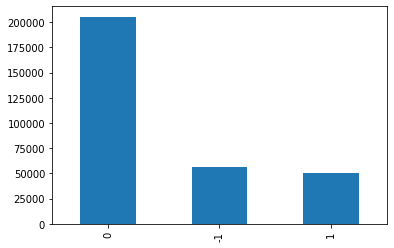

In [139]:
all_data['target'].value_counts().plot(kind='bar')

Нужно будет не забыть учесть несбалансированность таргета в модели

In [140]:
all_data.drop(labels='feature_51', axis=1, inplace=True)

In [141]:
num_cols = ['feature_4', 'feature_5', 'feature_17', 'feature_18', 
        'feature_19', 'feature_47', 'feature_48', 'feature_49',
        'feature_50', 'feature_53', 'feature_54', 'feature_55', 
        'feature_82', 'feature_83', 'feature_84', 'feature_85',
        'feature_86', 'feature_87', 'feature_88', 'feature_89',
        'feature_90', 'feature_91', 'feature_92', 'feature_93',
        'feature_94', 'feature_95', 'feature_96', 'feature_97',
        'feature_98', 'feature_99', 'feature_100', 'feature_101',
        'feature_102', 'feature_103', 'feature_104', 'feature_105',
        'feature_106', 'feature_108', 'feature_109', 'feature_111', 
        'feature_112', 'feature_113', 'feature_118', 'feature_119', 
        'feature_120', 'feature_121', 'feature_122', 'feature_123', 
        'feature_124']

cat_cols = ['feature_1', 'feature_2', 'feature_3', 'feature_6',
        'feature_7', 'feature_8', 'feature_9','feature_10', 
        'feature_11', 'feature_12', 'feature_13', 'feature_14', 
        'feature_15', 'feature_16', 'feature_20', 'feature_21',
        'feature_22', 'feature_23', 'feature_24', 'feature_25',
        'feature_26', 'feature_27', 'feature_28', 'feature_29',
        'feature_30', 'feature_31', 'feature_32', 'feature_33',
        'feature_34', 'feature_35', 'feature_36', 'feature_37',
        'feature_38', 'feature_39', 'feature_40', 'feature_41',
        'feature_42', 'feature_43', 'feature_44', 'feature_45',
        'feature_46', 'feature_52', 'feature_56', 'feature_57',
        'feature_58', 'feature_59', 'feature_60', 'feature_61',
        'feature_62', 'feature_63', 'feature_64', 'feature_65',
        'feature_66', 'feature_67', 'feature_68', 'feature_69',
        'feature_70', 'feature_71', 'feature_72', 'feature_73',
        'feature_74', 'feature_75', 'feature_76', 'feature_77',
        'feature_78', 'feature_79', 'feature_80', 'feature_81',
        'feature_107', 'feature_110', 'feature_114', 'feature_115', 
        'feature_116', 'feature_117']    

прологорифмируем наши числовые колонки

In [142]:
for col in cat_cols:
    all_data[col] = ce.TargetEncoder(smoothing=0).fit_transform(all_data[col], all_data.target)

Так как тяжело сказать, не зная природы этих данных, что значат 0 и 1 в категориальных колонках, закодируем TargetEncoder.

In [143]:
# for column in num_cols:
#     print(column)
#     print(outliers(all_data, column))

Выбросов много, но, возможно, это нормальные значения для этих признаков.

In [144]:
all_data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(all_data[num_cols]), columns = all_data[num_cols].columns)

In [145]:
# imp_num = pd.Series(f_classif(all_data[num_cols], all_data['target'])[0], index = num_cols)
# imp_num.sort_values(inplace = True)
# imp_num.plot(figsize = (25, 25), kind = 'barh')

In [146]:
# imp_cat = pd.Series(mutual_info_classif(all_data[cat_cols], all_data['target'],
#                                      discrete_features =True), index = cat_cols)
# imp_cat.sort_values(inplace = True)
# imp_cat.plot(figsize = (25, 25), kind = 'barh')

In [174]:
train_df = all_data.query('sample == 1').drop(['sample'], axis=1)
test_df = all_data.query('sample == 0').drop(['sample'], axis=1)

In [175]:
X = train_df.drop(['target'], axis=1)
y = train_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_test_1 = X_test.copy()
X_test = X_test.drop(['ID'], axis=1)
X_train = X_train.drop(['ID'], axis=1)

In [176]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

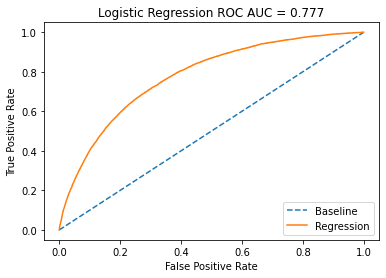

In [177]:
probs = lr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Без балансировки класса:
Logistic Regression ROC AUC = 0.775

## С балансировкой класса:
Logistic Regression ROC AUC = 0.777

In [178]:
print('accuracy_score:',accuracy_score(y_test,y_pred))
print('precision_score:',precision_score(y_test,y_pred))
print('recall_score:',recall_score(y_test,y_pred))
print('f1_score:',f1_score(y_test,y_pred))
print('matthews_corrcoef:',matthews_corrcoef(y_test,y_pred))

accuracy_score: 0.7087405206786022
precision_score: 0.37573529411764706
recall_score: 0.703441494591937
f1_score: 0.48983224922971574
matthews_corrcoef: 0.3413849041546904


## Без балансировки класса:
- accuracy_score: 0.8134039559064967
- precision_score: 0.6030433344359908
- recall_score: 0.1792527040314651
- f1_score: 0.2763586750549534
- matthews_corrcoef: 0.25385032059417406

## С балансировкой класса:

- accuracy_score: 0.7087405206786022
- precision_score: 0.37573529411764706
- recall_score: 0.703441494591937
- f1_score: 0.48983224922971574
- matthews_corrcoef: 0.3413849041546904

[Text(0, 0.5, 'True'), Text(0.5, 0, 'Predicted')]

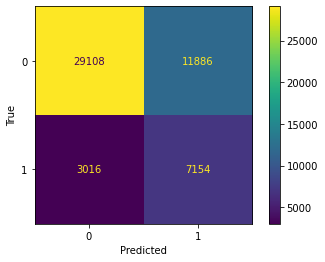

In [179]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

По метрикам модель получилась на троечку.

# Модель с отбором параметров:

In [180]:
# train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# feature_selector = SequentialFeatureSelector(LogisticRegression(class_weight="balanced"),
#            k_features=15,
#            forward=True,
#            verbose=2,
#            scoring='f1',
#            cv=4)

In [181]:
# features = feature_selector.fit(np.array(train_features.fillna(0)), train_labels)

In [182]:
# filtered_features= train_features.columns[list(features.k_feature_idx_)]
# filtered_features

In [183]:
# filtered_features = ['feature_2', 'feature_4', 'feature_19', 'feature_50', 'feature_52',
#        'feature_53', 'feature_66', 'feature_77', 'feature_79', 'feature_82',
#        'feature_98', 'feature_102', 'feature_113', 'feature_114',
#        'feature_119']

In [184]:
# lr = LogisticRegression(class_weight="balanced")

# lr.fit(X_train[filtered_features].fillna(0), y_train)
# y_pred = lr.predict(X_test[filtered_features].fillna(0))

In [185]:
# probs = lr.predict_proba(X_test[filtered_features].fillna(0))
# probs = probs[:,1]


# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print('accuracy_score:',accuracy_score(y_test,y_pred))
# print('precision_score:',precision_score(y_test,y_pred))
# print('recall_score:',recall_score(y_test,y_pred))
# print('f1_score:',f1_score(y_test,y_pred))
# print('matthews_corrcoef:',matthews_corrcoef(y_test,y_pred))

# cm = confusion_matrix(y_test, y_pred)
# cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
# cmd.plot()
# cmd.ax_.set(xlabel='Predicted', ylabel='True')

- accuracy_score: 0.7081150809162693
- precision_score: 0.37233358344945866
- recall_score: 0.6830875122910521
- f1_score: 0.4819619814069654
- matthews_corrcoef: 0.32949346881270186
- ROC AUC = 0.756

результат немного хуже, чем без подбора важных параметров, но при этом не должно быть большой разницы с результатами на тестовом файле

In [224]:
results_df = pd.DataFrame(data={'Вероятность':probs, 'Всего в группе': 1, 'Кол-во target 1':y_test})
results_df = pd.DataFrame(results_df.groupby(pd.cut(results_df['Вероятность'], np.arange(0, 1.0+0.1, 0.1))).sum())
results_df = results_df.drop(['Вероятность'], axis=1)
results_df

,Всего в группе,Кол-во target 1
Вероятность,,
"(0.0, 0.1]",1349,27
"(0.1, 0.2]",7250,248
"(0.2, 0.3]",8652,591
"(0.3, 0.4]",7710,878
"(0.4, 0.5]",7163,1272
"(0.5, 0.6]",6495,1592
"(0.6, 0.7]",5211,1826
"(0.7, 0.8]",3792,1685
"(0.8, 0.9]",2321,1249


# Тест на данных verify.csv

In [230]:
X_test = test_df.drop(['ID', 'target'], axis=1)
y_pred = lr.predict_proba(X_test)
verify_results_df = pd.DataFrame(data={'ID':test_df['ID'], 'score':y_pred[:,1]})
verify_results_df.to_csv('verify_results.csv', sep=';', index=False)

In [231]:
verify_results_df

,ID,score
255820,255821,0.02
255821,255822,0.57
255822,255823,0.66
255823,255824,0.11
255824,255825,0.32
...,...,...
311845,311846,0.42
311846,311847,0.17
311847,311848,0.19
311848,311849,0.52


Вывод:     
Пропущенные значения заполнил медианой, так как нет информации о природе данных.     
Таргет несбаланирован - решение использовать параметр class_weight="balanced" у логистической регрессии.     
Бороться с переобучением можно встроенным регуляризатором l2, или уменьшить количество признаков, как я подобрал 15 лучших методом Forward Feature Selection, или сбором большего количества данных.      
Насчёт аномалий сложно сказать, но выбросов много, желательно более точно понимать что означает каждый признак.      
Из плохих данных можно попробовать получить новые признаки.      
Чтобы получать более качественные данных, нужно более внимательно подойти к процессу их получения, будь то парсинг и тд.